In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Mehta1@karan",
                             database = "ecommerce")

cur = db.cursor()



1. List all unique cities where customers are located.
   

In [33]:
querry = """ select distinct customer_city from customers """
cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017
   

In [14]:


querry = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(querry)

data = cur.fetchall()
"total orders placed in 2017 are " , data [0] [0]

('total orders placed in 2017 are ', 45101)

3. Find the total sales per category.

In [21]:
querry = """ select products.product_category category , round(sum( payments.payment_value),2) sales
from products join order_items on products.product_id = order_items.product_id 
join payments on payments.order_id = order_items.order_id
group by category"""

cur.execute(querry)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category" , "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


4. Calculate the percentage of orders that were paid in installments.

In [25]:
querry = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*) * 100  from payments """

cur.execute(querry)

data =cur.fetchall()
"percentage of orders that were paid in installments is" , data [0] [0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

5. Count the number of customers from each state.

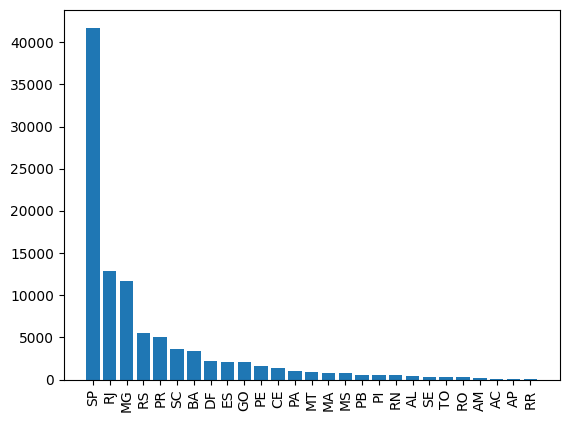

In [32]:
querry = """ select customer_state , count(customer_id)  from customers group by customer_state """

cur.execute(querry)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "Customer_count"])
df = df.sort_values (by = "Customer_count", ascending= False)

plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation = 90)
plt.show()

1. Calculate the number of orders per month in 2018.

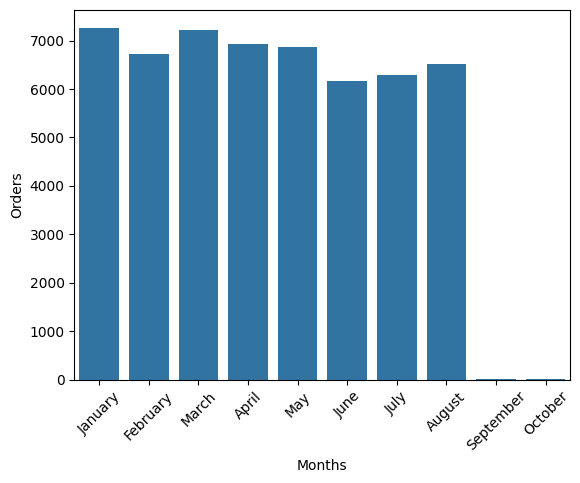

In [44]:
querry = """ select monthname(order_purchase_timestamp) Months, count(order_id) Orders  from orders where year(order_purchase_timestamp) = 2018 
group by Months"""

cur.execute(querry)

data =cur.fetchall()
df = pd.DataFrame(data, columns = ["Months", "Orders"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
sns.barplot(x=df["Months"], y= df["Orders"], data = df, order = o)
plt.xticks(rotation =45)
plt.show()


2. Find the average number of products per order, grouped by customer city.

In [7]:
querry = """ with order_count as 
(select orders.customer_id, orders.order_id, count(orders.order_id) as oc from orders join 
order_items on orders.order_id = order_items.order_id 
group by orders.customer_id, orders.order_id)

select  customers.customer_city , round(avg(order_count.oc),2) from customers join
order_count on customers.customer_id = order_count.customer_id 
group by customers.customer_city """

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["city", "average no of products"])
df.head(5)


,city,average no of products
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


3. Calculate the percentage of total revenue contributed by each product category.

In [8]:
querry = """ select products.product_category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) from payments join 
order_items on payments.order_id = order_items.order_id join products
on products.product_id = order_items.product_id 
group by products.product_category """

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["Product category", "percentage of total revenue"])
df.head(5)


,Product category,percentage of total revenue
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,bed table bath,10.70
4,automotive,5.32


4. Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
querry = """select products.product_category , round(avg(order_items.price),2) ,count(order_items.product_id) from order_items join products 
on order_items.product_id = products.product_id 
group by products.product_category"""

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["Product category", "order_count" ,"price"])

arr1 = df["order_count"]
arr2 = df["price"]

a= np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is ",a[0][1])

the correlation between price and number of times a product has been purchased is  -0.10631514167157562


5. Calculate the total revenue generated by each seller, and rank them by revenue.

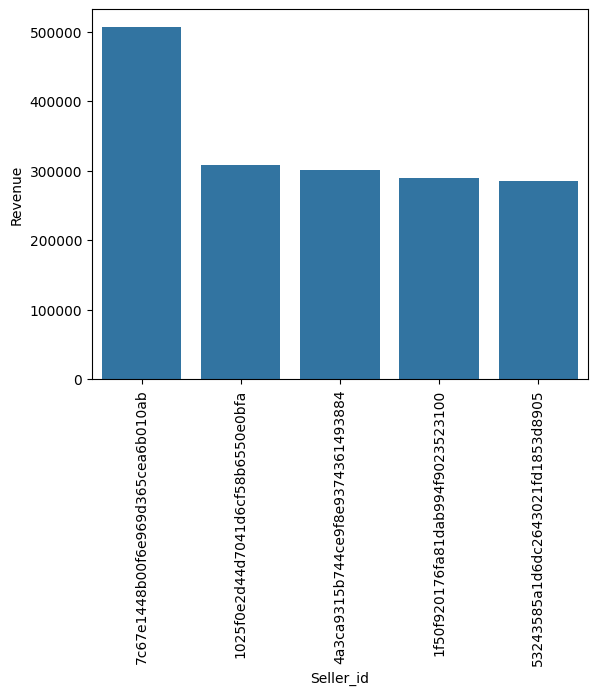

In [24]:

querry = """select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id , round(sum(payments.payment_value),2) as revenue from payments
join order_items on payments.order_id = order_items.order_id
group by order_items.seller_id) as a"""


cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["Seller_id", "Revenue","rank"])
df= df.head(5)

sns.barplot(x ="Seller_id",y = "Revenue", data =df)
plt.xticks(rotation = 90)
plt.show()

1. Calculate the moving average of order values for each customer over their order history.

In [26]:

querry = """select customer_id, order_purchase_timestamp, payment, avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row)as mov_avg from
(select orders.customer_id , orders.order_purchase_timestamp, payments.payment_value as payment 
from payments join orders 
on payments.order_id = orders.order_id) as a """

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["customer_id", "o_P_t","payment", "mov_avg"])
df

,customer_id,o_P_t,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


2. Calculate the cumulative sales per month for each year.

In [27]:

querry = """select years, months, payment, sum(payment) over (order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years, 
month(orders.order_purchase_timestamp) as months, round(sum(payments.payment_value),2) as payment from orders
join payments on orders.order_id = payments.order_id
group by years, months 
order by years, months) as a;"""

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


3. Calculate the year-over-year growth rate of total sales.

In [28]:

querry = """with a as (select year(orders.order_purchase_timestamp) as years, 
 round(sum(payments.payment_value),2) as payment from orders
join payments on orders.order_id = payments.order_id
group by years 
order by years)

select years, ((payment- lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from a"""

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "yoy % growth"])
df

,Years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


4. Identify the top 3 customers who spent the most money in each year.

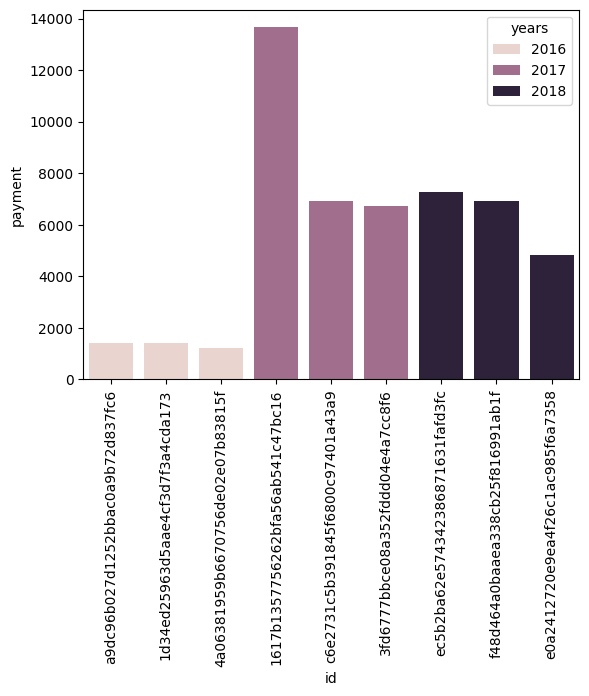

In [29]:

querry = """select years, customer_id, payment, d_rank from 
(select orders.customer_id , year(orders.order_purchase_timestamp) years,  sum(payments.payment_value) as payment,
 dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value)
desc) d_rank from orders join
payments on orders.order_id = payments.order_id 
group by orders.customer_id,  year(orders.order_purchase_timestamp)
) as a
where d_rank <=3 """

cur.execute(querry)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x ="id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()